In [ ]:
# hide
%load_ext autoreload
%autoreload 2

In [ ]:
# hide
from nbdev import *

In [ ]:
# hide
import json
import ipywidgets as widgets

from pathlib import Path
from tqdm import tqdm

from ipyannotator.base import Settings
from ipyannotator.mltypes import InputImage, OutputImageLabel
from ipyannotator.annotator import Annotator
from ipyannotator.datasets.factory_legacy import DS, get_settings, _combine_train_test
from ipyannotator.helpers import Tutorial

# Tutorial: Image classification

## Select Dataset

In [ ]:
# You can choose between 3 datasets ['cifar10', 'oxford_flowers', 'CUB_200'] that you can download.
# We use a artifical generated classification dataset by default that doesn't require downloading.
dataset = DS.ARTIFICIAL_CLASSIFICATION
# dataset = DS.CIFAR10
# dataset = DS.OXFORD102
# dataset = DS.CUB200

## Setup annotator

In [ ]:
# get special project settings for selected dataset

settings_ = get_settings(dataset)
settings_.project_file, settings_.image_dir

In [ ]:
input_ = InputImage(image_dir=settings_.image_dir,
                    image_width=settings_.im_width,
                    image_height=settings_.im_height)

output_ = OutputImageLabel(label_dir=settings_.label_dir,
                           label_width=settings_.label_width,
                           label_height=settings_.label_height)
input_.dir, output_.dir

In [ ]:
anni = Annotator(input_, output_, settings_)

## EXPLORE

You can explore dataset with `next/previous` buttons to check visualized labels.

In [ ]:
# explorer = anni.explore(k=3)
explorer = anni.explore()
explorer

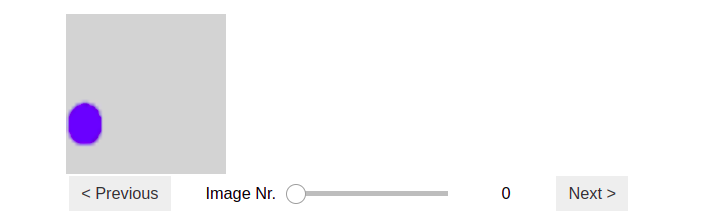

## CREATE

In [ ]:
if dataset == DS.ARTIFICIAL_CLASSIFICATION:
    ! rm -rf data/artificial_classification/create_results
elif dataset == DS.CIFAR10:
    ! rm -rf data/cifar10/create_results
elif dataset == DS.OXFORD102:
    ! rm -rf data/oxford-102-flowers/create_results
elif dataset == DS.CUB200:
    ! rm -rf data/CUB_200_2011/create_results

You can try to annotate by hand,
but be sure to have some pieces incorrectly annotated,
thus you prepare good set for `improve` step below

In [ ]:
creator = anni.create()

creator

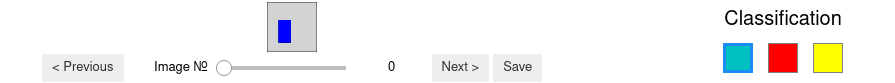

#### To imitate human work on currnt step, let's randomly annotate all the images automatically:

In [ ]:
#SKIP THIS STEP IF YOU ANNOTATE MANUALLY

HELPER = Tutorial(dataset, settings_.project_path)
HELPER.annotate_randomly(creator)

Let's get first 3 images marked for one class, depending on dataset (RED, CAT, etc..)

In [ ]:
if dataset == DS.ARTIFICIAL_CLASSIFICATION:
    #RED
    print([k for k, v in creator.to_dict().items() if 'red.jpg' in v][:3])
elif dataset == DS.CIFAR10:
    #CAT
    print([k for k, v in creator.to_dict().items() if 'cat.jpg' in v][:3])
else:
    pass

## IMPROVE

Lets group some annotators together, so we can go through all annotated images but for each classs separately.

Each grid shows images belonging to the __same__ class. 

You should __mark all errors__ (images, which belongs to __different__ class)

!! Dont forget to click __SAVE__ button when finished with each class:

#### improve

In [ ]:
all_improvers = anni.improve()

In [ ]:
len(all_improvers)

let's select first two classes to mark the errors

In [ ]:
all_improvers[:2]

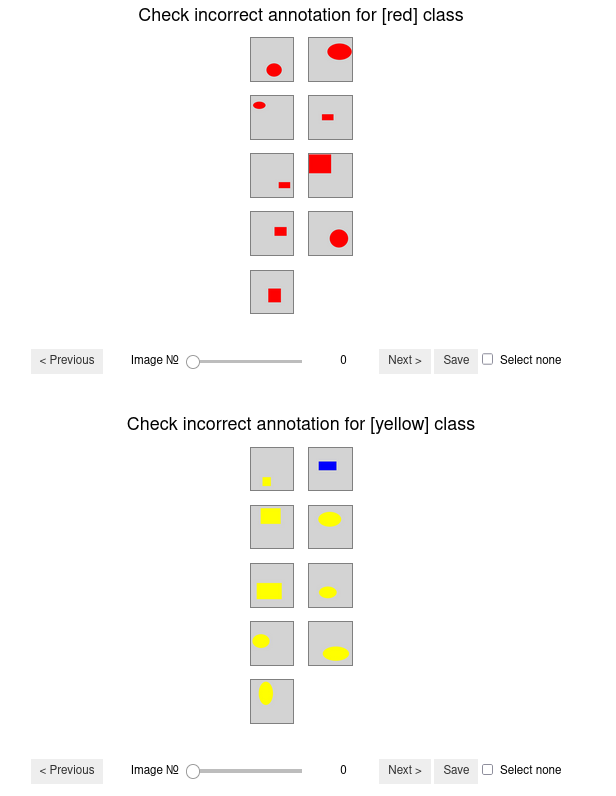

#### To imitate human work on current step, let's fix the incorrect annotations automatically:

In [ ]:
#SKIP THIS STEP IF YOU CHECK ANNOTATIONS MANUALLY
HELPER.fix_incorrect_annotations(all_improvers)

Now we can get list of all marked images, which should be reclassified:

In [ ]:
reclasify_this = [[c for c, v in i.to_dict().items() if v['answer']] for i in all_improvers]
#  Show 10 files with incorrect labels
for a in reclasify_this:
    print(a[:10])

### Postprocessing..

Also, automatically generarted json file for each class can be used for further processing.

Let's load one json for a random class and show filenames marked as incorrect on previous step for this class:

In [ ]:
from glob import glob
from random import sample
import pandas as pd

random_class = sample(glob(str(Path(
    settings_.project_path) / settings_.result_dir / 'missed') + '/*'), 1)[0]

random_class_annotation = pd.read_json(Path(random_class) / 'annotations.json').T

random_misssed = list(
    random_class_annotation[random_class_annotation['answer'] == True].index.values)  # noqa: E712

#  show 10 files with incorrect label for the random class
random_misssed[:10]

# result may be empty, if all annotations are correct